### Rede Neural

In [10]:
# Implementação e salvamento da rede treinada

In [11]:
# Carga do modelo e previsãp

### Compara previsão com teste

In [12]:
# Gráfico da previsão x teste

### Valores previstos

In [13]:
# Próximo passo

In [14]:
# Conjunto de passos futuros

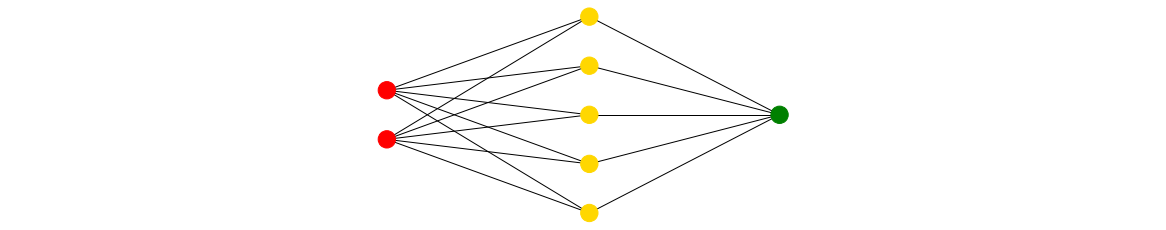

In [47]:
import itertools
import matplotlib.pyplot as plt
import networkx as nx

from networkx.utils import pairwise

subset_sizes = [2, 5, 1]
subset_color = ["red", "gold", "green"]


def multilayered_graph(*subset_sizes):
    extents = pairwise(itertools.accumulate((0,) + subset_sizes))
    layers = [range(start, end) for start, end in extents]
    G = nx.Graph()
    for (i, layer) in enumerate(layers):
        G.add_nodes_from(layer, layer=i)
    for layer1, layer2 in pairwise(layers):
        G.add_edges_from(itertools.product(layer1, layer2))
    return G


G = multilayered_graph(*subset_sizes)
color = [subset_color[data["layer"]] for v, data in G.nodes(data=True)]
pos = nx.multipartite_layout(G, subset_key="layer")
plt.figure(figsize=(16, 3))

pos[0][0] = -2
pos[1][0] = -2
pos[7][0] = 2

nx.draw(G, pos, node_color=color, with_labels=False)
plt.axis("equal")
plt.show()